# Install dependencies

In [1]:
# Download the dataset
!wget https://s3.amazonaws.com/axionautdataset/Datasets+2.zip

--2018-11-22 07:45:49--  https://s3.amazonaws.com/axionautdataset/Datasets+2.zip
Résolution de s3.amazonaws.com (s3.amazonaws.com)… 52.216.137.174
Connexion à s3.amazonaws.com (s3.amazonaws.com)|52.216.137.174|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 1719750362 (1,6G) [application/zip]
Enregistre : «Datasets+2.zip»

Datasets+2.zip      100%[===================>]   1,60G  3,35MB/s    ds 8m 26s  

2018-11-22 07:54:15 (3,24 MB/s) - «Datasets+2.zip» enregistré [1719750362/1719750362]



In [2]:
#!unzip self-driving-toy-car.zip 
!unzip Datasets+2.zip

Archive:  Datasets+2.zip
   creating: Datasets/
  inflating: Datasets/.DS_Store      
   creating: __MACOSX/
   creating: __MACOSX/Datasets/
  inflating: __MACOSX/Datasets/._.DS_Store  
   creating: Datasets/ironcar_data/
  inflating: Datasets/ironcar_data/.DS_Store  
   creating: __MACOSX/Datasets/ironcar_data/
  inflating: __MACOSX/Datasets/ironcar_data/._.DS_Store  
   creating: Datasets/ironcar_data/old_track/
  inflating: Datasets/ironcar_data/old_track/balanced_iron_Y.npy  
   creating: __MACOSX/Datasets/ironcar_data/old_track/
  inflating: __MACOSX/Datasets/ironcar_data/old_track/._balanced_iron_Y.npy  
  inflating: Datasets/ironcar_data/old_track/balanced_iron_X.npy  
  inflating: __MACOSX/Datasets/ironcar_data/old_track/._balanced_iron_X.npy  
  inflating: __MACOSX/Datasets/ironcar_data/._old_track  
   creating: Datasets/ironcar_data/new_track/
  inflating: Datasets/ironcar_data/new_track/y_chicane.npy  
   creating: __MACOSX/Datasets/ironcar_data/new_track/
  inflating: __MA

# Initialize constants
This is hands-on is heavily inspired of this [notebook](https://github.com/Axionable/Axionaut).

Here, the behaviour of the car is very simple, and can be greatly improved.
The neural network learns the steering between 5 possibilities: hard right, right, straight, left and hard left.

No acceleration, no slowing down, only one car on the track. Even if that model is that simple, it was the winner of the second [IronCar France](http://ironcar.org/) robocar competition (in 2018).

In [3]:
def label_decoder(line):
    '''Returns human-readible label from target array.
    
    '''
    if np.array_equal(line, [1,0,0,0,0]):
        return 'hard_right'
    elif np.array_equal(line, [0,1,0,0,0]):
        return 'soft_right'
    elif np.array_equal(line, [0,0,1,0,0]):
        return 'straight'
    elif np.array_equal(line, [0,0,0,1,0]):
        return 'soft_left'
    elif np.array_equal(line, [0,0,0,0,1]):
        return 'hard_left'
    else:
        print('Error: Label not recognized.')
        return 

    
def label_decoder_int(line):
    '''Convert label from array to integer.
    
    '''
    if np.array_equal(line, [1,0,0,0,0]):
        return -1
    elif np.array_equal(line, [0,1,0,0,0]):
        return -0.5
    elif np.array_equal(line, [0,0,1,0,0]):
        return 0
    elif np.array_equal(line, [0,0,0,1,0]):
        return 0.5
    elif np.array_equal(line, [0,0,0,0,1]):
        return 1
    else:
        print('Error: Label not recognized.')
        return

In [4]:
import numpy as np

# Load dada from Numpy array
X_axio = np.load('Datasets/axionable_data/X_train_axio.npy')
Y_axio = np.load('Datasets/axionable_data/Y_train_axio.npy')
print('Axionable data Loaded. Shape = ', np.shape(X_axio))

Axionable data Loaded. Shape =  (26449, 90, 250, 3)


In [5]:

# New track - Double chicane
X_chicane = np.load('Datasets/ironcar_data/new_track/x_chicane.npy')
Y_chicane = np.load('Datasets/ironcar_data/new_track/y_chicane.npy')
# Old track - Balanced dataset
X_iron = np.load('Datasets/ironcar_data/old_track/balanced_iron_X.npy')
Y_iron = np.load('Datasets/ironcar_data/old_track/balanced_iron_Y.npy')
# New double Chicane
X_chicane2 = np.load('Datasets/new/x_chicane.npy')
Y_chicane2 = np.load('Datasets/new/y_chicane.npy')

In [6]:

# Concatenate both augmented datasets in a single one
X = np.concatenate((X_axio, X_chicane, X_iron, X_chicane2))
Y = np.concatenate((Y_axio, Y_chicane, Y_iron, Y_chicane2))
print('Total X shape after augmentation = ', np.shape(X))

Total X shape after augmentation =  (47165, 90, 250, 3)


In [7]:
import pandas as pd

# Convert targets to a Pandas Data Frame
df = pd.DataFrame(Y)

# Convert targets to integer (-1 = hard_right, 1 = hard_left)
df['direction'] = df.apply(label_decoder_int, axis=1)

# Check that the dataset is representative of reality, in order to avoid biases: 
# most of the cases should be "going straight forward", some should be "right" or "left", fewer should be "full right" or "full left"
df.direction.plot.hist()

# Read the data

## Read an image and the corresponding steering angle
The data were collected by driving the car manually, with a wifi remote, and saving the commands of the driver.

X contains the images watched by the car, Y contains the corresponding commands issued by the driver.

In [8]:
import cv2
import numpy as np

def read_image_and_steering(img_number):
  
  image = X[img_number]
  steer = Y[img_number]
  
  return image, steer 

In [9]:

def draw_steer(image, steer, color):
    center = (image.shape[1]//2, image.shape[0]//2)
    offset = (image.shape[1]//2 + int(-label_decoder_int(steer)*image.shape[1]/2), image.shape[0]//2)
    
    img = image.copy()
    cv2.arrowedLine(img, center, offset, color=color, thickness=1, tipLength=0.4)      
    
    return img

[0. 0. 0. 1. 0.]


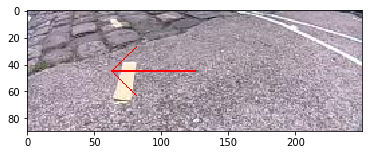

In [10]:
import random
import matplotlib.pyplot as plt


img_test, steer_test = read_image_and_steering(random.randint(0, X_axio.shape[0]))

print(steer_test)
img_test_with_steer = draw_steer(img_test, steer_test, (255, 0, 0))
plt.imshow(img_test_with_steer)

##Augment the dataset
As usual, we add random transformations to the images, so that the neural network would learn to drive in different conditions: dark, light, shadows...

In [11]:

def horizontal_flip(img, steer):
    """Horizontal image flipping and angle correction.
    Img: Input image to transform in Numpy array.
    Angle: Corresponding label. Must be a 5-elements Numpy Array.
    """    
    return np.fliplr(img), np.flipud(steer)


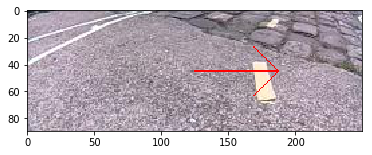

In [12]:
img_test_flip, steer_test_flip = horizontal_flip(img_test, steer_test)
img_test_flip_with_steer = draw_steer(img_test_flip, steer_test_flip, (255, 0, 0))
plt.imshow(img_test_flip_with_steer)

In [13]:

def augment_brightness_camera_images(image):
    '''Random bright augmentation (both darker and brighter).
    
    Returns:
    Transformed image and label.
    '''
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

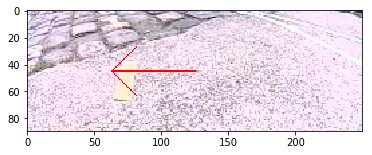

In [14]:
img_test_bright = augment_brightness_camera_images(img_test)
img_test_bright_with_steer = draw_steer(img_test_bright, steer_test, (255, 0, 0))
plt.imshow(img_test_bright_with_steer)

In [15]:

def add_random_shadow(image):
    '''Add random dark shadows to a given image.
    Returns:
    Transformed image and label.
    '''
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image


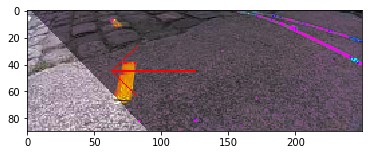

In [16]:
img_test_shadow = add_random_shadow(img_test)
img_test_shadow_with_steer = draw_steer(img_test_shadow, steer_test, (255, 0, 0))
plt.imshow(img_test_shadow_with_steer)

In [17]:

import skimage.exposure as exposure

def night_effect(img, vmin=185, vmax=195):
    """Change road color to black simulating night road.
    Returns
    Transformed image and label.
    """
    limit = random.uniform(vmin,vmax)
    low_limit = 146 
    int_img = exposure.rescale_intensity(img, in_range=(low_limit,limit), out_range='dtype')
    
    return int_img

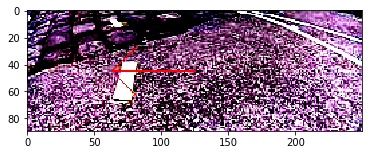

In [18]:

img_test_night = night_effect(img_test)
img_test_night_with_steer = draw_steer(img_test_night, steer_test, (255, 0, 0))
plt.imshow(img_test_night_with_steer)

In [19]:

def adjust_gamma_dark(image, min_=0.7, max_=0.8):
    '''Gamma correction to generate darker images.
    Image: Image in Numpy format (90,250,3)
    Label: Corresponding label of the image.
    Min: Minimum gamma value (the lower the darker)
    Max: Maximum gamma value (the higher the brigther) 
    Return:
    Transformed image and label.
    '''
    # build a lookup table mapping the pixel values [0, 255] to
    gamma = random.uniform(min_,max_)
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)


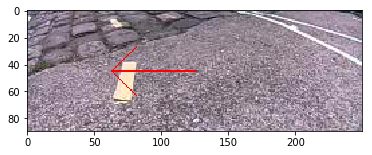

In [20]:

img_test_dark = adjust_gamma_dark(img_test)
img_test_dark_with_steer = draw_steer(img_test_dark, steer_test, (255, 0, 0))
plt.imshow(img_test_dark_with_steer)

In [21]:

def augment(image, steer):
    
    if np.random.random() > 0.75:
        image = adjust_gamma_dark(image)
    elif np.random.random() > 0.75:
        image = night_effect(image)
    elif np.random.random() > 0.75:
        image = add_random_shadow(image)
    elif np.random.random() > 0.75:
        image = augment_brightness_camera_images(image)
    elif np.random.random() > 0.75:
        image = augment_brightness_camera_images(image)
        image =  add_random_shadow(image)
        image, steer = horizontal_flip(image, steer)
                
    return image, steer

[0. 0. 0. 1. 0.]


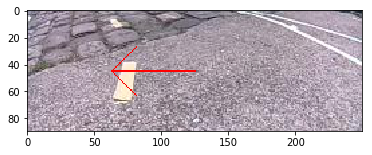

In [22]:
img_test_augmented, steer_augmented = augment(img_test, steer_test)
print(steer_augmented)
img_test_augmented_with_steer = draw_steer(img_test_augmented, steer_augmented, (255, 0, 0))
plt.imshow(img_test_augmented_with_steer)

##Create a generator for Keras

In [23]:
from itertools import chain
from itertools import islice

def batch_generator(imgs, batch_size):
    """
    Implement batch generator that yields items in batches of size batch_size.
    There's no need to shuffle input items, just chop them into batches.
    Remember about the last batch that can be smaller than batch_size!
    Input: any iterable (list, generator, ...). You should do `for item in items: ...`
        In case of generator you can pass through your items only once!
    Output: In output yield each batch as a list of items.
    """
    
    ### YOUR CODE HERE
    # https://stackoverflow.com/questions/24527006/split-a-generator-into-chunks-without-pre-walking-it
    iterator = iter(imgs)
    for first in iterator:        
        yield list(chain([first], islice(iterator, batch_size - 1)))

In [24]:

def normalize(image):
    '''Return image centered around 0 with +- 0.5.
    image: Image to transform in Numpy array.
    '''
    return image/255.-.5

In [25]:

def train_generator(imgs_numbers, batch_size, shuffle = True, jitter = True, norm=True):
  
    if shuffle: np.random.shuffle(imgs_numbers)
      
    while True:  # so that Keras can loop through this as long as it wants
        for batch in batch_generator(imgs_numbers, batch_size):
          
            # prepare batch images
            batch_imgs = []
            batch_targets = []
            for img_num in batch:
              
                image, steer = read_image_and_steering(img_num)
                
                if jitter: image, steer = augment(image, steer)
                if norm:   image = normalize(image)
                  
                batch_imgs.append(image)
                batch_targets.append(steer)
            # stack images into 4D tensor [batch_size, img_size, img_size, 3]
            batch_imgs = np.stack(batch_imgs, axis=0)
            # convert targets into 2D tensor [batch_size, num_classes]
            batch_targets = np.stack(batch_targets, axis=0)
            yield batch_imgs, batch_targets

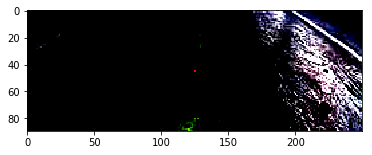

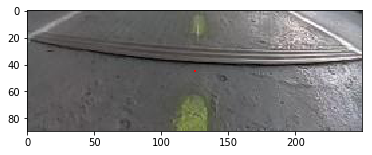

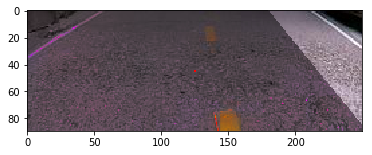

In [26]:

# test training generator
NB_IMGS_TEST = 3

img_numbers = np.random.choice(len(X), size=NB_IMGS_TEST)
for imgs, steers in train_generator(img_numbers, NB_IMGS_TEST, norm=False):
    for img, steer in zip(imgs, steers):
      img = draw_steer(img, steer, (255, 0, 0))
      plt.imshow(img)
      plt.show()
    break

# Construct the neural network
The proposed architecture is a slightly modified version of the PilotNet published by [Nvidia](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf). This architecture is powerful to modelize all possible driving situations while simple enough to run on the raspberry pi 3 B+. Dropout of 10% was added on two classifier layers to avoid overfitting.

In [27]:
IMG_SIZE = X.shape[1:]
IMG_SIZE

(90, 250, 3)

In [29]:

from tensorflow.python.keras.layers import Input, Dense, Flatten, Dropout, Conv2D
from tensorflow.python.keras.models import Model

def model_categorical(input_size= IMG_SIZE, dropout=0.1):
    '''Generate an NVIDIA AutoPilot architecture.
    Input_size: Image shape (90, 250, 3), adjust to your desired input.
    Dropout: Proportion of dropout used to avoid model overfitting.
    This model ONLY predicts steering angle as a 5-elements array encoded with a Softmax output.
    The model is already compiled and ready to be trained.
    '''

    
    img_in = Input(shape=input_size, name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB
    x = Conv2D(filters=24, kernel_size=(5,5), strides=(2,2), activation='relu')(img_in)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
    x = Conv2D(filters=32, kernel_size=(5,5), strides=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
    x = Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu

    # Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

    x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
    x = Dense(100, activation='relu')(x)                                    # Classify the data into 100 features, make all negatives 0
    x = Dropout(dropout)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    x = Dense(50, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
    x = Dropout(dropout)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)
    
    #categorical output of the angle
    angle_out = Dense(5, activation='softmax', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0
    
    model = Model(inputs=[img_in], outputs=[angle_out])
    
    return model
  
model = model_categorical()
    

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 90, 250, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 123, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 60, 32)        19232     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 28, 64)         51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 26, 64)         36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 24, 64)         36928     
_________________________________________________________________
flattened (Flatten)          (None, 6144)              0         
__________

In [31]:

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop  = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=5, mode='auto', verbose=1)
checkpoint  = ModelCheckpoint('weights.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)

In [32]:

from sklearn.model_selection import train_test_split

# batch generator
BATCH_SIZE = 32
#BATCH_SIZE = 16

imgs_num_train, imgs_num_test = train_test_split(list(range(len(X))), test_size=0.15)

num_train = len(imgs_num_train)//BATCH_SIZE
num_valid = len(imgs_num_test)//BATCH_SIZE


In [33]:

model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.fit_generator(generator = train_generator(imgs_num_train, BATCH_SIZE),
                    steps_per_epoch = num_train, 
                    epochs  = 6, 
                    verbose = 1,
                    validation_data = train_generator(imgs_num_test, BATCH_SIZE, jitter = False), 
                    validation_steps = num_valid, 
                    callbacks = [early_stop, checkpoint])

Epoch 1/6
1251/1252 [============================>.] - ETA: 0s - loss: 0.5857 - acc: 0.7794
Epoch 00001: val_loss improved from inf to 0.16168, saving model to weights.hdf5
1252/1252 [==============================] - 50s 40ms/step - loss: 0.5855 - acc: 0.7795 - val_loss: 0.1617 - val_acc: 0.9408
Epoch 2/6
1251/1252 [============================>.] - ETA: 0s - loss: 0.2275 - acc: 0.9211
Epoch 00002: val_loss improved from 0.16168 to 0.06888, saving model to weights.hdf5
1252/1252 [==============================] - 48s 38ms/step - loss: 0.2274 - acc: 0.9211 - val_loss: 0.0689 - val_acc: 0.9786
Epoch 3/6
1251/1252 [============================>.] - ETA: 0s - loss: 0.1552 - acc: 0.9469
Epoch 00003: val_loss improved from 0.06888 to 0.06101, saving model to weights.hdf5
1252/1252 [==============================] - 48s 38ms/step - loss: 0.1551 - acc: 0.9470 - val_loss: 0.0610 - val_acc: 0.9797
Epoch 4/6
1251/1252 [============================>.] - ETA: 0s - loss: 0.1258 - acc: 0.9575
Epoch 

# Check the predictions of the steering angle

[0. 1. 0. 0. 0.]
[[1.7284838e-02 4.9099216e-01 4.8995203e-01 3.4566651e-04 1.4253265e-03]]


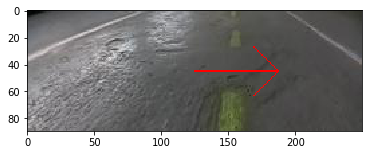

In [34]:

img_test, steer_test = read_image_and_steering(random.choice(imgs_num_test))

print(steer_test)
img_test = draw_steer(img_test, steer_test, (255, 0, 0))
plt.imshow(img_test)

steer_pred = model.predict(np.expand_dims(normalize(img_test), axis=0))
print(steer_pred)
    